# Get Best Run

grace annotated 4 new validation regions: https://cell-map.slack.com/archives/C04N9JUFQK1/p1695934591940359, so will use these

we will use her initial large "validation region" as testing region

annotations_20230929_115330.csv is validation region 2

annotations_20230929_115745.csv is validation region 3

annotations_20230929_115914.csv is validation regions 4 and 5


In [20]:
import pandas as pd

original_annotations = pd.read_csv("../preprocessing/annotations_20230510_114340.csv")
validation_region_1 = pd.read_csv("../preprocessing/annotations_20230829_173628.csv")
validation_region_2 = pd.read_csv("../preprocessing/annotations_20230929_115330.csv")
validation_region_3 = pd.read_csv("../preprocessing/annotations_20230929_115745.csv")
validation_region_4_and_5 = pd.read_csv("annotations_20230929_115914.csv")
print(
    f"all annotations: {len(original_annotations) + len(validation_region_1) + len(validation_region_2) + len(validation_region_3)+ len(validation_region_4_and_5)}"
)
print(
    f"all annotations assuming region 1 is used for test: {len(original_annotations) + len(validation_region_2) + len(validation_region_3) + len(validation_region_4_and_5)}"
)  # if use validation 1 as test

all annotations: 4429
all annotations assuming region 1 is used for test: 3455


In [34]:
import numpy as np
df = validation_region_4_and_5

pd_starts = (
    np.array([df["start x (nm)"], df["start y (nm)"], df["start z (nm)"]]).T
)
pd_ends = (
    np.array([df["end x (nm)"], df["end y (nm)"], df["end z (nm)"]]).T 
)
pd_centers = np.array(list(
    map(tuple, np.round(((pd_starts + pd_ends) / 2)).astype(int))
))

in_box_5 = (pd_centers[:,0]<=126598) & (pd_centers[:,0]>=118478) & (pd_centers[:,1]<=38009) & (pd_centers[:,1]>=30502) & (pd_centers[:,2]<=50384) & (pd_centers[:,2]>=34005)

In [37]:
print(len(original_annotations)+len(validation_region_4_and_5)+len(validation_region_1))

3515


In [15]:
import json
from dacapo.store.create_store import (
    create_config_store,
)
from dacapo.experiments import Run
import matplotlib.pyplot as plt
import pandas as pd
import os

df = pd.DataFrame(
    columns=[
        "run",
        "iteration",
        "parameter",
        "full_path",
        "rand_voi",
        "rand_voi_bkgd",
        "detection_f1",
        "detection_iou_f1",
        "detection_avg_iou",
        "detection_iou_avg_iou",
    ]
)

base_dir = "/nrs/cellmap/ackermand/validation_inference/"
for run_name in os.listdir(base_dir):
    for iteration in range(5000, 200000 + 1, 5000):
        for idx, bias in enumerate([0.1, 0.25, 0.5, 0.75, 0.9]):
            parameter = f"WatershedPostProcessorParameters(id={idx}, bias={bias})"
            dir_name = f"/nrs/cellmap/ackermand/validation_inference/{run_name}/processed.n5/iteration_{iteration}/{parameter}"
            file_name = f"{dir_name}/attributes.json"
            try:
                with open(file_name) as f:
                    data = json.load(f)
                detection = data["detection"]
                f1 = (
                    2
                    * detection["tp"]
                    / (2 * detection["tp"] + detection["fp"] + detection["fn"])
                )
                detection_iou = data["detection_iou"]
                f1_iou = (
                    2
                    * detection_iou["tp"]
                    / (
                        2 * detection_iou["tp"]
                        + detection_iou["fp"]
                        + detection_iou["fn"]
                    )
                )
                row = [
                    run_name,
                    iteration,
                    parameter,
                    dir_name,
                    data["rand_voi"],
                    data["rand_voi_include_background"],
                    f1,
                    f1_iou,
                    detection["avg_iou"],
                    detection_iou["avg_iou"],
                ]
                df.loc[len(df.index)] = row
            except:
                pass
                # print(run_name,iteration)

In [16]:
removed_dummy = df[df["run"].str.contains("removed_dummy")]
f1_max = max(
    removed_dummy["detection_f1"].max(), removed_dummy["detection_iou_f1"].max()
)
df_maxs = removed_dummy[
    (removed_dummy["detection_f1"] == f1_max)
    | (removed_dummy["detection_iou_f1"] == f1_max)
]
print(f1_max, df_maxs["full_path"].values)

0.975 ['/nrs/cellmap/ackermand/validation_inference/finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_removed_dummy_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1/processed.n5/iteration_130000/WatershedPostProcessorParameters(id=2, bias=0.5)']


In [18]:
detection_iou

{'avg_distance': 0, 'avg_iou': 0, 'fn': 40, 'fp': 0, 'tp': 0}

# Check f1 score in new validation region

In [3]:
from funlib.persistence import open_ds
from funlib.geometry import Roi

roi = Roi((19952, 9736, 153344), (13464, 14064, 15104))
best = open_ds(
    "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    "processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
)
gt = open_ds(
    "/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
    "larger_validation_crop",
)
best = best.to_ndarray(roi)
gt = gt.to_ndarray(roi)

KeyboardInterrupt: 

In [12]:
import dask
import dask.array as da
import numpy as np
import dask.diagnostics

# target array to be processed block-by-block
# use `da.overlap.overlap` for overlapped blocks
gt_da = da.random.randint(low=1, high=10, size=(4, 4), dtype=int, chunks=2)
test_da = da.random.randint(low=1, high=10, size=(4, 4), dtype=int, chunks=2)


# function that returns a python dictionary
def get_overlap_dict(gt, test):
    out_dict = {}
    gt_ids = np.unique(gt)
    for gt_id in gt_ids:
        if gt_id > 0:
            test_ids, test_counts = np.unique(test[gt == gt_id], return_counts=True)
            nonzeros = test_ids > 0
            out_dict[gt_id] = [
                test_ids[nonzeros],
                test_counts[nonzeros],
            ]
    return out_dict


# list comprehension to iterate over the blocks, lazily
delayed_result = [
    dask.delayed(get_overlap_dict)(gt_block, test_block)
    for (gt_block, test_block) in zip(gt_da.blocks, test_da.blocks)
]

result = dask.delayed(list)(delayed_result)
with dask.diagnostics.ProgressBar():
    print(result.compute())

[########################################] | 100% Completed | 102.84 ms
[{2: [array([4]), array([1])], 3: [array([6]), array([1])], 4: [array([7]), array([1])], 5: [array([6]), array([1])], 6: [array([8]), array([1])], 7: [array([4, 6]), array([1, 1])], 8: [array([4]), array([1])]}, {3: [array([3, 8]), array([1, 1])], 4: [array([5]), array([1])], 5: [array([9]), array([1])], 6: [array([6]), array([1])], 9: [array([2, 3, 5]), array([1, 1, 1])]}]


In [1]:
import dask.diagnostics
import dask.array as da
from dask.distributed import Client, LocalCluster
import numpy as np
from scipy.ndimage import binary_erosion
import socket
import itertools
from funlib.persistence import open_ds
from funlib.geometry import Roi
import itertools

# target array to be processed block-by-block
# use `da.overlap.overlap` for overlapped blocks
with LocalCluster(n_workers=8, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        print(
            f'Click here to monitor job: {client.dashboard_link.replace("127.0.0.1", socket.gethostname())}'
        )

        roi = Roi((19952, 9736, 153344), (13464, 14064, 15104)).snap_to_grid((8, 8, 8))
        start_original = np.array(roi.begin / 8).astype(int)
        end_original = np.array(roi.end / 8).astype(int)

        # need to snap to 256 since we are using that for chunk size and because chunks start at 0,0,0
        # in voxels
        roi = roi.snap_to_grid((256 * 8, 256 * 8, 256 * 8))

        # start_prediction_mask = np.array([22400.0, 12800.0, 0.0], dtype=int) / 128
        # prediction_mask_da = da.from_zarr(
        #    "/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
        #    "jrc_22ak351-leaf-3m",
        #    chunks=(16, 16, 16),
        # )
        # prediction_mask_da = da.pad(
        #     prediction_mask_da,
        #     [(start_prediction_mask[i] - start[i], 0) for i in range(3)],
        #     mode="constant",
        #     constant_values=0,
        # )

        prediction_mask_da = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
            "jrc_22ak351-leaf-3m",
            chunks=(128, 128, 128),
        )

        start_prediction = np.array(roi.begin / 128).astype(int)
        end_prediction = np.array(roi.end / 128).astype(int)
        prediction_mask_da = prediction_mask_da[
            start_prediction[0] : end_prediction[0],
            start_prediction[1] : end_prediction[1],
            start_prediction[2] : end_prediction[2],
        ]
        prediction_mask_da = (
            prediction_mask_da.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
        )
        prediction_mask_da = prediction_mask_da.rechunk((256, 256, 256))

        start = np.array(roi.begin / 8).astype(int)
        end = np.array(roi.end / 8).astype(int)
        test_da = da.from_zarr(
            "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
            "processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
            chunks=(256, 256, 256),
        )

        test_da = da.pad(
            test_da,
            [
                (start_original[i] - start[i], end[i] - end_original[i])
                for i in range(3)
            ],
            mode="constant",
            constant_values=0,
        )
        test_da = test_da.rechunk((256, 256, 256))

        gt_da = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
            "larger_validation_crop",
            chunks=(256, 256, 256),
        )
        gt_da = gt_da[
            start[0] : end[0],
            start[1] : end[1],
            start[2] : end[2],
        ]

        # function that returns a python dictionary
        def get_overlap_dict(true_components, test_components, prediction_mask):
            out_dict = {}
            # taken from funlib.evaluate detection
            # change logical_and to logical_or since we want total counts
            # prediction_mask = (
            #     prediction_mask.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
            # )
            test_components = np.multiply(test_components, prediction_mask)
            both_fg_mask = np.logical_or(true_components > 0, test_components > 0)
            both_fg_true = true_components[both_fg_mask].ravel()
            both_fg_test = test_components[both_fg_mask].ravel()
            if both_fg_true.size > 0:
                pairs, counts = np.unique(
                    np.array([both_fg_true, both_fg_test]), axis=1, return_counts=True
                )

                for gt_id, test_id, count in zip(pairs[0], pairs[1], counts):
                    out_dict[(gt_id, test_id)] = count
                return out_dict

    # list comprehension to iterate over the blocks, lazily
    delayed_result = [
        dask.delayed(get_overlap_dict)(
            gt_da.blocks[inds],
            test_da.blocks[inds],
            prediction_mask_da.blocks[
                inds
            ],  # tuple([int(ind // 16) for ind in inds])],
        )
        for inds in itertools.product(*map(range, gt_da.blocks.shape))
    ]

    result = dask.delayed(list)(delayed_result)
    with dask.diagnostics.ProgressBar():
        res = result.compute()

import pickle

with open("validation_processing_result.pickle", "wb") as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

Click here to monitor job: http://ackermand-ws2:8787/status
[########################################] | 100% Completed | 135.72 s


In [80]:
prediction_mask_da = da.from_zarr(
    "/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
    "jrc_22ak351-leaf-3m",
    chunks=(128, 128, 128),
)

start_prediction = np.array(roi.begin / 128).astype(int)
end_prediction = np.array(roi.end / 128).astype(int)
prediction_mask_da = prediction_mask_da[
    start_prediction[0] : end_prediction[0],
    start_prediction[1] : end_prediction[1],
    start_prediction[2] : end_prediction[2],
]
prediction_mask_da = (
    prediction_mask_da.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
)
prediction_mask_da = prediction_mask_da.rechunk((256, 256, 256))
prediction_mask_da

dask.array<rechunk-merge, shape=(2048, 2048, 2304), dtype=uint8, chunksize=(256, 256, 256), chunktype=numpy.ndarray>

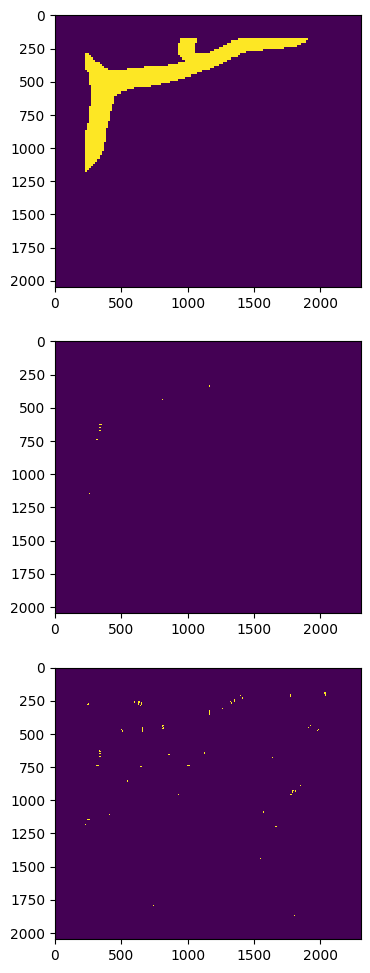

In [3]:
import matplotlib.pyplot as plt

plt.subplots(3, 1, figsize=(20, 12))
plt.subplot(3, 1, 1)
p = prediction_mask_da[:, 1000, :]
p = p.compute()
plt.imshow(p, interpolation="none")

gt = gt_da[:, 1000, :]
gt = gt.compute()
plt.subplot(3, 1, 2)
plt.imshow(gt > 0, interpolation="none")

test = test_da[:, 1000, :]
test = test.compute()
plt.subplot(3, 1, 3)
plt.imshow(test > 0, interpolation="none")

In [10]:
import pickle
import numpy as np


with open("validation_processing_result.pickle", "rb") as f:
    res = pickle.load(f)
test_id_counts = {}
gt_id_counts = {}
for current_dict in res:
    if current_dict:
        for k, v in current_dict.items():
            gt_id, test_id = k
            if gt_id > 0:
                if test_id not in test_id_counts:
                    test_id_counts[test_id] = v
                else:
                    test_id_counts[test_id] += v

                if gt_id not in gt_id_counts:
                    gt_id_counts[gt_id] = v
                else:
                    gt_id_counts[gt_id] += v

vs = np.array(list(test_id_counts.values()))
print(np.sum(np.array(list(gt_id_counts.values())) > 0), np.sum(vs > 0))

974 892


In [2]:
import dask.array as da
from funlib.geometry import Roi
import numpy as np

roi = Roi((19952, 9736, 153344), (13464, 14064, 15104)).snap_to_grid((8, 8, 8))
# need to snap to 256 since we are using that for chunk size and because chunks start at 0,0,0
# in voxels
s_original = np.array(roi.begin / 8).astype(int)
e = np.array(roi.end / 8).astype(int)

roi = roi.snap_to_grid((256 * 8, 256 * 8, 256 * 8))
s = np.array(roi.begin / 8).astype(int)

test_da = da.from_zarr(
    "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    "processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
    chunks=(256, 256, 256),
)
test_da = da.pad(
    test_da,
    [(s_original[i] - s[i], 0) for i in range(3)],
    mode="constant",
    constant_values=0,
)
test_da = test_da.rechunk((256, 256, 256))

gt_da = da.from_zarr(
    "/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
    "larger_validation_crop",
    chunks=(256, 256, 256),
)
gt_da = gt_da[s[0] : e[0], s[1] : e[1], s[2] : e[2]]

In [21]:
a = np.random.random((2, 2, 2))
b = np.random.random((2, 2, 2))

print(a, b)

[[[0.89552253 0.5178612 ]
  [0.64727431 0.79562215]]

 [[0.5017423  0.24596905]
  [0.98897249 0.52345661]]] [[[0.59480061 0.92093337]
  [0.7366641  0.24027499]]

 [[0.65958781 0.68071869]
  [0.36993547 0.05152294]]]


In [27]:
pairs, counts = np.unique(np.array([a.ravel(), b.ravel()]), axis=1, return_counts=True)

In [29]:
pairs[0]

array([0.24596905, 0.5017423 , 0.5178612 , 0.52345661, 0.64727431,
       0.79562215, 0.89552253, 0.98897249])

In [11]:
b = a[a > 2]
np.unique(b)

array([3, 4])

In [ ]:
import dask.array as da
from dask.distributed import Client, LocalCluster
import numpy as np
from scipy.ndimage import binary_erosion
import socket
import itertools
from funlib.persistence import open_ds
from funlib.geometry import Roi

# startup dask
with LocalCluster(n_workers=8, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        print(
            f'Click here to monitor job: {client.dashboard_link.replace("127.0.0.1", socket.gethostname())}'
        )

        # get nucleus data
        offset = np.array([13048, 54080, 15944])
        dimension = np.array(
            [10696, 10536, 12960]
            # [100,100,100]
            # [5000, 5000, 5000]
        )

        roi = Roi(offset, dimension).snap_to_grid((16, 16, 16))
        offset = np.array(roi.begin / 8)
        dimension = np.array(roi.shape / 8)

        # now offset = (1630, 6760, 1992)
        # now dimension = (1338, 1318, 1622)
        # used to be (1631, 6760, 1993)
        # (1337, 1317, 1620)

        nucleus = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/jrc_mus-liver-zon-1.n5",
            "nucleus",
            chunks=(256, 256, 256),
        )
        s = (offset / 2).astype(int)
        e = ((offset + dimension) / 2).astype(int)
        nucleus = nucleus[s[0] : e[0], s[1] : e[1], s[2] : e[2]]
        nucleus = nucleus == 93  # the specific nucleus we are choosing

        # get surface
        surface = nucleus ^ binary_erosion(nucleus)

        # convert from 16 nm to 8 nm resolution
        surface = surface.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)
        nucleus = nucleus.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)

        # get pore voxels
        pores = da.from_zarr(
            "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
            "processed/2023-07-19-masked/nuclear_pores_affs_lsds/0/fragments_relabeled/",
            chunks=(512, 512, 512),
        )

        # so basically pores starts at whatever my predictions box is, but reading from zarr it sees that corner as 0,0,0
        # not what the ROI actually is. (the nucleus predictions do actually start at 0,0,0 tho)
        # so i have to subtract to make it line up

        pred_roi = Roi(
            np.array([7704, 54080, 14152]), np.array([315048, 74488, 85432])
        ).snap_to_grid((16, 16, 16))
        print(pred_roi)
        pred_offset = np.array(pred_roi.begin) / 8  # to get to voxels
        print(pred_offset)
        pores_offset = offset - pred_offset
        print(pores_offset)
        s = (pores_offset).astype(int)
        e = ((pores_offset + dimension)).astype(int)

        pores = pores > 0
        pores = pores[s[0] : e[0], s[1] : e[1], s[2] : e[2]]

        # summer to return count of surface exposed faces
        def summer(n, s):
            return da.sum(da.map_overlap(get_surface_counts, n, s, depth=1))
        
        da.reduction(
        # do calculations
        prod = da.multiply(surface, pores)  # gets where surface and pores overlap
        num = summer(nucleus, prod).compute()  # specifically counts surface of pores

        print(f"# surface faces at nuclear pores: {num}")

        den = summer(nucleus, surface).compute()  # counts surface of whole nuc

        print(f"# surface faces: {den}")
        print(f"Fraction of surface faces at nuclear pores: {num/den}")

In [5]:
import numpy as np

best.dtype

dtype('uint64')

0

In [1]:
f1_max = max(df["detection_f1"].max(), df["detection_iou_f1"].max())
df_maxs = df[(df["detection_f1"] == f1_max) | (df["detection_iou_f1"] == f1_max)]
print(f1_max, df_maxs["full_path"].values)

NameError: name 'df' is not defined

# Write out segmentations as annotations

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from funlib.persistence import open_ds

mask = open_ds(
    "/nrs/cellmap/jonesa/jrc_22ak351-leaf-3m/crop352_mask_revised.zarr", "s0"
)
mask.materialize()
frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/leaf-gall/jrc_22ak351-leaf-3m.n5/fragments_relabeled.csv"
)
volume = frags["Volume (nm^3)"].to_numpy()
offsets = np.array([22400.0, 12800.0, 0])
count = 0
ids = frags["Object ID"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy() - offsets[0]
com_y = frags["COM Y (nm)"].to_numpy() - offsets[1]
com_x = frags["COM X (nm)"].to_numpy() - offsets[2]
ids_to_keep = np.ones_like(ids, dtype=bool)
for idx, (id, v, z, y, x) in tqdm(enumerate(zip(ids, volume, com_z, com_y, com_x))):
    try:
        if (
            v < (10**3 * 8**3)
            or mask.data[int(z // 128), int(y // 128), int(x // 128)] > 0
        ):
            ids_to_keep[idx] = 0
            # print(np.sum(v<10*10*10*8*8*8)/len(v),len(v))
            # plt.hist(v,bins=list(range(0,3_000_000,100000)))
            # ds.data
    except:
        ids_to_keep[idx] = 0

391068it [00:00, 509063.50it/s]


In [27]:
ids_to_keep.sum()

190714

In [29]:
import struct
import os
import struct
import numpy as np
import json
from time import sleep
from datetime import datetime
import pandas as pd
from tqdm import tqdm


def write_precomputed_annotations(annotation_type, annotations):
    # write_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_directory = "/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/segmentations/fragments_relabeled"

    os.makedirs(f"{output_directory}/spatial0")
    if annotation_type == "line":
        coords_to_write = 6
    else:
        coords_to_write = 3

    with open(f"{output_directory}/spatial0/0_0_0", "wb") as outfile:
        total_count = len(annotations)
        buf = struct.pack("<Q", total_count)
        for annotation in tqdm(annotations):
            annotation_buf = struct.pack(f"<{coords_to_write}f", *annotation)
            buf += annotation_buf
        # write the ids at the end of the buffer as increasing integers
        id_buf = struct.pack(
            f"<{total_count}Q", *range(1, len(annotations) + 1, 1)
        )  # so start at 1
        # id_buf = struct.pack('<%sQ' % len(coordinates), 3,1 )#s*range(len(coordinates)))
        buf += id_buf
        outfile.write(buf)

    max_extents = annotations.reshape((-1, 3)).max(axis=0) + 1
    max_extents = [int(max_extent) for max_extent in max_extents]
    info = {
        "@type": "neuroglancer_annotations_v1",
        "dimensions": {"x": [1, "nm"], "y": [1, "nm"], "z": [1, "nm"]},
        "by_id": {"key": "by_id"},
        "lower_bound": [0, 0, 0],
        "upper_bound": max_extents,
        "annotation_type": annotation_type,
        "properties": [],
        "relationships": [],
        "spatial": [
            {
                "chunk_size": max_extents,
                "grid_shape": [1, 1, 1],
                "key": "spatial0",
                "limit": 1,
            }
        ],
    }

    with open(f"{output_directory}/info", "w") as info_file:
        json.dump(info, info_file)

    return output_directory.replace(
        "/groups/cellmap/cellmap/ackermand/",
        "precomputed://https://cellmap-vm1.int.janelia.org/dm11/ackermand/",
    )


frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/leaf-gall/jrc_22ak351-leaf-3m.n5/fragments_relabeled.csv"
)
id = frags["Object ID"]
com_x = frags["COM X (nm)"].to_numpy()
com_y = frags["COM Y (nm)"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy()
min_x = frags["MIN X (nm)"].to_numpy()
min_y = frags["MIN Y (nm)"].to_numpy()
min_z = frags["MIN Z (nm)"].to_numpy()
max_x = frags["MAX X (nm)"].to_numpy()
max_y = frags["MAX Y (nm)"].to_numpy()
max_z = frags["MAX Z (nm)"].to_numpy()
annotations = np.column_stack(
    (
        min_x[ids_to_keep],
        min_y[ids_to_keep],
        min_z[ids_to_keep],
        max_x[ids_to_keep],
        max_y[ids_to_keep],
        max_z[ids_to_keep],
    )
)
# write_precomputed_annotations("line", annotations)
write_precomputed_annotations(
    "point",
    np.column_stack((com_x[ids_to_keep], com_y[ids_to_keep], com_z[ids_to_keep])),
)

100%|██████████| 190714/190714 [00:14<00:00, 12860.16it/s]


'precomputed://https://cellmap-vm1.int.janelia.org/dm11/ackermand/neuroglancer_annotations/segmentations/fragments_relabeled'

In [3]:
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np

frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/leaf-gall/jrc_22ak351-leaf-3m.n5/fragments_relabeled.csv"
)
id = frags["Object ID"]
com_x = frags["COM X (nm)"].to_numpy()
com_y = frags["COM Y (nm)"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy()
density = gaussian_kde(np.column_stack((com_x, com_y, com_z)).T)

TypeError: Invalid shape (100, 100, 100) for image data

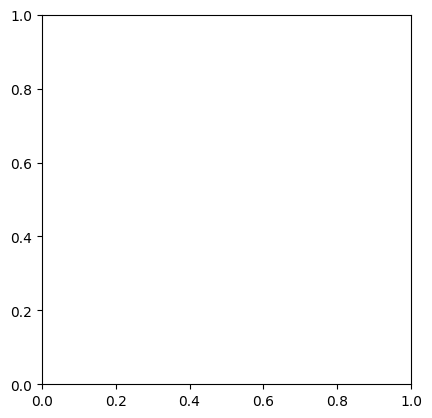

In [13]:
import numpy as np
from scipy import stats


def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    m3 = np.random.normal(size=n)
    return m1 + m2, m1 - m2, m3


m1, m2, m3 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
zmin = m3.min()
zmax = m3.max()

X, Y, Z = np.mgrid[xmin:xmax:100j, ymin:ymax:100j, zmin:zmax:100j]
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
values = np.vstack([m1, m2, m3])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(
    np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax, zmin, zmax]
)
ax.plot(m1, m2, "k.", markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()